# Mall customers

## In your notebook

Acquire data from mall_customers.customers in mysql database.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from acquire import get_connection

In [2]:
def new_mall_data():
    '''
    This function reads the mall customer data from CodeUp database into a df,
    write it to a csv file, and returns the df.
    '''
    sql_query = '''
                select * 
                from customers
                '''
    df = pd.read_sql(sql_query, get_connection('mall_customers'))
    df.to_csv('mall_df.csv')
    return df

In [3]:
df = new_mall_data()

In [4]:
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
df = df.set_index('customer_id')

In [6]:
df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


Summarize data (include distributions and descriptive statistics).

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


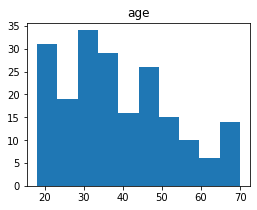

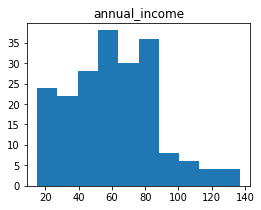

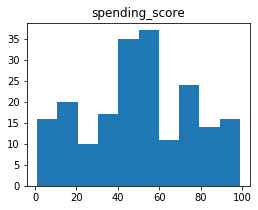

In [8]:
for col in df.columns:
    if df[col].dtype != object:
        plt.figure(figsize=(4,3))
        plt.hist(df[col])
        plt.title(col)
        plt.show()

In [9]:
df.gender.value_counts()

Female    112
Male       88
Name: gender, dtype: int64

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
annual_income,200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0
spending_score,200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0


Detect outliers using IQR.

In [11]:
def detect_outliers(df):
    for col in df.select_dtypes('int64'):
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        k = 1.5
        lower_bound = q1 - (k * iqr)
        upper_bound = q3 + (k * iqr)
        lower_outliers = df[col][df[col] < lower_bound]
        upper_outliers = df[col][df[col] > upper_bound]
        if lower_outliers.empty == True & upper_outliers.empty == True:
            print(f'There are no outliers in {col}. \n') 
        elif (lower_outliers.empty == False) & (upper_outliers.empty == True):
            print(f'The lower outliers in {col} are \n{lower_outliers}\n')
        elif (upper_outliers.empty == False) & (lower_outliers.empty == True):
            print(f'The upper outliers in {col} are \n{upper_outliers}\n')
        elif (upper_outliers.empty == False) & (lower_outliers.empty == False):
            print(f'The upper outliers in {col} are \n{upper_outliers}\n')
            print(f'The lower outliers in {col} are \n{lower_outliers}\n')


In [12]:
detect_outliers(df)

There are no outliers in age. 

The upper outliers in annual_income are 
customer_id
199    137
200    137
Name: annual_income, dtype: int64

There are no outliers in spending_score. 



- Dropping the two outliers

In [13]:
df = df.drop([199, 200])

In [14]:
df

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
194,Female,38,113,91
195,Female,47,120,16
196,Female,35,120,79


Encode categorical columns using a one hot encoder.

In [15]:
gender_dummies = pd.get_dummies(df.gender, drop_first=True)

df = pd.concat([df, gender_dummies], axis=1)

df = df.drop(columns=['gender'])

In [16]:
df

,age,annual_income,spending_score,Male
customer_id,,,,
1,19,15,39,1
2,21,15,81,1
3,20,16,6,0
4,23,16,77,0
5,31,17,40,0
...,...,...,...,...
194,38,113,91,0
195,47,120,16,0
196,35,120,79,0


Handles missing values.

- There are no missing values

Split data (train, validate, and test split).

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
def mall_split(df):
    train_and_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_and_validate, test_size=.25, random_state=123)
    return train, validate, test

In [19]:
train, validate, test = mall_split(df)

In [21]:
train.shape, validate.shape, test.shape

((118, 4), (40, 4), (40, 4))

In [22]:
train.head()

,age,annual_income,spending_score,Male
customer_id,,,,
182,32,97,86,0
49,29,40,42,0
35,49,33,14,0
186,30,99,97,1
114,19,64,46,1


Scaling

In [23]:
import sklearn.preprocessing

In [24]:
#assigns the scaling method as min-max scaler
scaler = sklearn.preprocessing.MinMaxScaler()

#identifies the columns to scale
columns_to_scale = ['age', 'annual_income', 'spending_score']

#adds '_scaled' to the end of the newly scaled columns to identify differences
new_column_names = [c + '_scaled' for c in columns_to_scale]

#fts the columns to the scaler
scaler.fit(train[columns_to_scale])

#concatonates the newly created scaled columns to their respective data sets,
#adds 'new_column_names' as the label to the added columns
#uses the original index since the new columns no longer have an index
train = pd.concat([
    train,
    pd.DataFrame(scaler.transform(train[columns_to_scale]), columns=new_column_names, index=train.index),
], axis=1)
validate = pd.concat([
    validate,
    pd.DataFrame(scaler.transform(validate[columns_to_scale]), columns=new_column_names, index=validate.index),
], axis=1)
test = pd.concat([
    test,
    pd.DataFrame(scaler.transform(test[columns_to_scale]), columns=new_column_names, index=test.index),
], axis=1)

In [25]:
train.head()

,age,annual_income,spending_score,Male,age_scaled,annual_income_scaled,spending_score_scaled
customer_id,,,,,,,
182,32,97,86,0,0.269231,0.738739,0.867347
49,29,40,42,0,0.211538,0.225225,0.418367
35,49,33,14,0,0.596154,0.162162,0.132653
186,30,99,97,1,0.230769,0.756757,0.979592
114,19,64,46,1,0.019231,0.441441,0.459184


wrangle_mall.py

Acquire data from mall_customers.customers in mysql database.
Split the data into train, validate, and split
One-hot-encoding
Missing values
Scaling

In [26]:
def wrangle_mall(cached=True):
    '''
    This function acquires wrangle_telco data, 
    splits into train, validate, and test,
    scales the numeric columns using min-max scaling,
    and adds the scaled columns to the respective split data sets
    '''
    #acquires 'wrangle_telco' and saves it as df
    df = new_mall_data(cached)
    #set 'customer_id' as index
    df = df.set_index('customer_id')
    #dropping the two upper outliers for annual_income
    df = df.drop([199, 200])
    #uses the function above to split the into train, validate and test
    ttrain, validate, test = mall_split(df)
    #assigns the scaling method as min-max scaler
    scaler = sklearn.preprocessing.MinMaxScaler()
    #identifies the columns to scale
    columns_to_scale = ['age', 'annual_income', 'spending_score']
    #adds '_scaled' to the end of the newly scaled columns to identify differences
    new_column_names = [c + '_scaled' for c in columns_to_scale]
    #fts the columns to the scaler
    scaler.fit(train[columns_to_scale])
    #concatonates the newly created scaled columns to their respective data sets,
    #adds 'new_column_names' as the label to the added columns
    #uses the original index since the new columns no longer have an index
    train = pd.concat([
        train,
        pd.DataFrame(scaler.transform(train[columns_to_scale]), columns=new_column_names, index=train.index),
    ], axis=1)
    validate = pd.concat([
        validate,
        pd.DataFrame(scaler.transform(validate[columns_to_scale]), columns=new_column_names, index=validate.index),
    ], axis=1)
    test = pd.concat([
        test,
        pd.DataFrame(scaler.transform(test[columns_to_scale]), columns=new_column_names, index=test.index),
    ], axis=1)
    #returns the data sets with the new respective scaled data
    return train, validate, test

In [27]:
from wrangle_mall import wrangle_mall

In [28]:
train, validate, test = wrangle_mall()

In [29]:
train.shape, validate.shape, test.shape

((118, 7), (40, 7), (40, 7))